In [ ]:
import numpy as np
import Backgammon as B
import agent as A
import flipped_agent as FA
import tensorflow as tf
import keras
import keras.layers as L
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy
from collections import deque

In [ ]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], []
        boards = np.vstack(boards)
        return moves, boards
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player):
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        return np.copy(self.board), reward, self.done
    
    def symbolic_step(self, move):
        board = np.copy(self.board)
        if len(move) != 0:
            for m in move:
                board = B.update_board(board = board, move = m, player = 1)
        reward = 0
        done = False
        if B.game_over(board):
            reward = 1
            done = True
        return board, reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

# PolicyGrad Agent

In [ ]:
class PolicyGradient:
    def __init__(self, sess, gamma = 0.99, learning_rate = 1e-3, entropy = 0.1,
                epsilon = 1, epsdecay = 0.999):
        
        self._gamma = gamma
        self._epsilon = epsilon
        self._epsdecay = epsdecay
        
        self._states = tf.placeholder("float32", (None, 29), name = "states")
        self._afterstates = tf.placeholder("float32", (None, 29), name = "afterstates")
        self._done = tf.placeholder("float32", (None, ), name = "dones")
        self._cumulative_rewards = tf.placeholder("float32", (None, ), name = "rewards")
        
        # Actor
        self.network = keras.models.Sequential()
        self.network.add(L.Dense(32))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Dense(32))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Dense(1))
        
        # Predictions
        
        ## Actor
        self._actor_logits = self.network(self._states)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        self._actor_entropy = -tf.reduce_sum(self._actor_policy * self._actor_log_policy)
        
        # Losses
        self._actor_loss = -tf.reduce_sum(self._actor_log_policy * self._cumulative_rewards)
        self._actor_loss -= entropy * self._actor_entropy
        
        self._optimizer = tf.train.AdamOptimizer(learning_rate)
        self._update = self._optimizer.minimize(self._actor_loss)
        
        self._s = sess
        self._s.run(tf.global_variables_initializer())
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._states: states})).flatten()
        if np.random.uniform() < self._epsilon:
            action = np.random.choice(np.arange(len(probs)), p = probs)
        else:
            action = np.argmax(probs)
            
        return action
    
    def update(self, states, rewards, afterstates, done):
        self._s.run(self._update, 
                    ({self._states: states, 
                      self._cumulative_rewards: rewards}))
        self._epsilon *= self._epsdecay
        
    def get_cumulative_rewards(self, rewards):
        rewards = np.array(rewards)
        R = np.zeros_like(rewards, dtype= "float32")
        r = 0.
        for i, reward in enumerate(reversed(rewards)):
            r += reward
            R[-(i + 1)] = r
            r *= self._gamma
        return R
    
    def ExamplePolicy(self):
        _, st = B.legal_moves(B.init_board(), B.roll_dice(), 1)
        
        out = np.round(self._s.run(self._actor_policy, ({self._states: st})) * 100)/100
        out = out.flatten()
        out.sort()
        return out[::-1]

# Actor Critic (Shared network)

In [49]:
class ActorCritic:
    def __init__(self, sess, gamma = 0.99, learning_rate = 1e-3, entropy = 0.1,
                epsilon = 1, epsdecay = 0.999):
        
        self._gamma = gamma
        self._epsilon = epsilon
        self._epsdecay = epsdecay
        
        self._states = tf.placeholder("float32", (None, 29), name = "states")
        self._currstates = tf.placeholder("float32", (None, 29), name = "currstates")
        #self._afterstates = tf.placeholder("float32", (None, 29), name = "afterstates")
        self._done = tf.placeholder("float32", (None, ), name = "dones")
        self._cumulative_rewards = tf.placeholder("float32", (None, ), name = "rewards")
        
        # Actor
        self.network = keras.models.Sequential()
        self.network.add(L.Dense(32))
        self.network.add(L.BatchNormalization())
        self.network.add(L.PReLU())
        self.network.add(L.Dense(64))
        self.network.add(L.BatchNormalization())
        self.network.add(L.PReLU())
        self.network.add(L.Dense(32))
        self.network.add(L.BatchNormalization())
        self.network.add(L.PReLU())
        self.network.add(L.Dense(1))
        
        # Predictions
        
        ## Critic
        self._state_values = tf.nn.tanh(self.network(self._currstates))
        self._afterstate_values = tf.nn.tanh(self.network(self._states)) * (1 - self._done)
        
        self._target_state_values = self._cumulative_rewards
        self._target_state_values += self._gamma * self._afterstate_values * (1 - self._done)
        
        self._advantage = self._cumulative_rewards + self._gamma * self._afterstate_values * (1 - self._done) - self._state_values
        
        
        
        ## Actor
        self._actor_logits = self.network(self._states)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        self._actor_entropy = -tf.reduce_mean(self._actor_policy * self._actor_log_policy)
        
        # Losses
        self._critic_loss = tf.reduce_mean((self._state_values - tf.stop_gradient(self._target_state_values))**2)
        self._actor_loss = -tf.reduce_mean(self._actor_log_policy * tf.stop_gradient(self._advantage))
        self._actor_loss -= entropy * self._actor_entropy
        
        self._optimizer = tf.train.AdamOptimizer(learning_rate)
        self._update = self._optimizer.minimize(self._actor_loss + self._critic_loss)
        
        self._s = sess
        self._s.run(tf.global_variables_initializer())
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._states: states})).flatten()
        if np.random.uniform() < self._epsilon:
            action = np.random.choice(np.arange(len(probs)), p = probs)
        else:
            action = np.argmax(probs)
            
        return action
    
    def update(self, states, currstates, rewards, done):
        self._s.run(self._update, 
                    ({self._states: states, 
                      self._currstates: currstates,
                      self._done: done,
                      self._cumulative_rewards: rewards}))
        self._epsilon *= self._epsdecay
        
    def get_cumulative_rewards(self, rewards):
        rewards = np.array(rewards)
        R = np.zeros_like(rewards, dtype= "float32")
        r = 0.
        for i, reward in enumerate(reversed(rewards)):
            r += reward
            R[-(i + 1)] = r
            r *= self._gamma
        return R
    
    def ExamplePolicy(self):
        _, st = B.legal_moves(B.init_board(), B.roll_dice(), 1)
        
        out = np.round(self._s.run(self._actor_policy, ({self._states: st})) * 100)/100
        out = out.flatten()
        out.sort()
        return out[::-1]

In [5]:
def PlayGame(player1, player2 = "random"):
    
    env = backgammon()
    
    players = [player1, player2]
    
    active = np.random.randint(2)
    
    currstates = [[], []]
    states = [[], []]
    rewards = [[], []]
    done = False

    while not done:
        dice = B.roll_dice()
        for _ in range(1 + int(dice[0] == dice[1])):

            possible_moves, possible_boards = env.legal_moves(dice, 1)
            n_actions = len(possible_moves)

            if n_actions == 0:
                break

            currstates[active].append(env.board)
            action = players[active].sample_action(possible_boards)
            new_board, reward, done = env.step(possible_moves[action], player = 1)

            rewards[active].append(reward)
            states[active].append(new_board)
            afterstates[active].append(old_board)

            if done:
                break
            
            env.swap_player()
            active = (active + 1) % 2

        if not done:
            dice = B.roll_dice()
            
            if player2 != "random":
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)

                        if n_actions == 0:
                            break

                        action = player2.sample_action(possible_boards)

                        new_board, reward, done = env.step(possible_moves[action], player = 1)

                        if done:
                            rewards[-1] = -1
                            break
                env.swap_player()
                
            else:
                for _ in range(1 + int(dice[0] == dice[1])):
                    old_state, reward, done = env.make_move(dice)
                    if done:
                        rewards[-1] = -1
                        break

    afterstates.append(old_board)
    afterstates = afterstates[2:]

    Dones = np.zeros(len(states))
    Dones[-1] = 1

    States = np.vstack(states)
    CumulativeRewards = player.get_cumulative_rewards(rewards)
    AfterStates = np.vstack(afterstates)

    if type != "compete"
        player1.update(states = States, 
                      rewards = CumulativeRewards,
                      afterstates = AfterStates, 
                      done = Dones)
    

SyntaxError: invalid syntax (<ipython-input-5-02a9ee519b92>, line 70)

In [5]:
s = tf.InteractiveSession()

In [50]:
AC = ActorCritic(sess = s, entropy = 1, learning_rate = 0.00025, gamma = 0.99)

In [11]:
PG = PolicyGradient(sess = s, entropy = 0.0, learning_rate=1e-4, gamma = 0.9)

In [41]:
AC.network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 32)                960       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 32)                32        
_________________________________________________________________
dense_45 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
p_re_lu_5 (PReLU)            (None, 64)                64        
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
__________

In [16]:
AC.ExamplePolicy()

array([0.06, 0.06, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.02, 0.02, 0.02, 0.02], dtype=float32)

# Stakt episode


## Spila við sjálft sig

Win percentage:  0.44
Agent epsilon:  0.05494344105065345


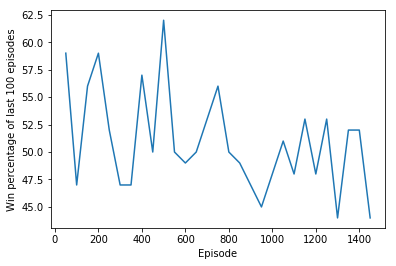

Example policy: 
 [0.49 0.49 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


KeyboardInterrupt: 

In [51]:
win_pct = []


for i in range(50):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        states = []
        currstates = []
        #afterstates = []
        rewards = []
        afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                currstates.append(env.board)
                #afterstates.append(env.board)
                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                states.append(new_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = AC.sample_action(possible_boards)
                        
                        new_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            rewards[-1] = -1
                            break
                            
                env.swap_player()
                            
        #afterstates.append(new_board)
        #afterstates = afterstates[2:]
        
        Dones = np.zeros(len(states))
        Dones[-1] = 1
        
        States = np.vstack(states)
        CumulativeRewards = AC.get_cumulative_rewards(rewards)
        CurrStates = np.vstack(currstates)
        #AfterStates = np.vstack(afterstates)
        
        
        AC.update(states = States, 
                  currstates = CurrStates,
                  #afterstates = AfterStates, 
                  rewards = CumulativeRewards,
                  done = Dones)
        
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    print("Agent epsilon: ", AC._epsilon)
    plt.figure()
    x = [(n + 1) * 50 for n in range(len(win_pct))]
    y = (100*np.array(win_pct)).astype('int')
    plt.plot(x, y)
    plt.xlabel('Episode')
    plt.ylabel('Win percentage of last 100 episodes')
    plt.savefig('tensorflow_random.pdf')
    plt.show()
    print("Example policy: \n", AC.ExamplePolicy())
    

Win percentage:  0.98
Agent epsilon:  0


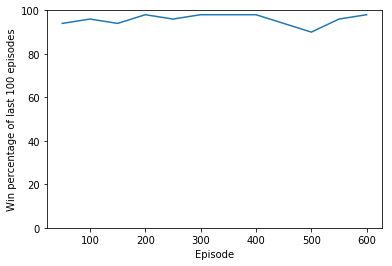

Example policy: 
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


KeyboardInterrupt: 

In [52]:
win_pct = []
AC._epsilon = 0
for i in range(100):

    wins = []

    for _ in range(50):

        env = backgammon()

        #states = []
        #currstates = []
        #afterstates = []
        #rewards = []
        #afterstates.append([])
        done = False

        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                #currstates.append(env.board)
                #afterstates.append(env.board)

                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)

                #rewards.append(reward)
                #states.append(new_board)

                if done:
                    break

            if not done:
                dice = B.roll_dice()

                for _ in range(1 + int(dice[0] == dice[1])):
                        new_board, reward, done = env.make_move(dice)
                        if done:
                            reward = -1
                            break

        #afterstates.append(new_board)
        #afterstates = afterstates[2:]

        #Dones = np.zeros(len(states))
        #Dones[-1] = 1

        #States = np.vstack(states)
        #CurrStates = np.vstack(currstates)
        #AfterStates = np.vstack(afterstates)
        #Rewards = AC.get_cumulative_rewards(rewards)


        #AC.update(states = States, 
        #          rewards = Rewards, 
        #          currstates = CurrStates,
        #          afterstates = AfterStates, 
        #          done = Dones)

        wins.append(int(reward == 1))

    win_pct.append(np.mean(wins))

    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    print("Agent epsilon: ", AC._epsilon)
    plt.figure()
    x = [(n + 1) * 50 for n in range(len(win_pct))]
    y = (100 * np.array(win_pct)).astype('int')
    plt.plot(x, y)
    plt.xlabel('Episode')
    plt.ylabel('Win percentage of last 100 episodes')
    plt.ylim(0, 100)
    #plt.savefig('tensorflow_random.pdf')
    plt.show()
    print("Example policy: \n", AC.ExamplePolicy())
    

In [ ]:
win_pct = []
#AC = ActorCritic(sess = s, entropy = 0.01, learning_rate = 0.001, gamma = 0.99,
#                epsilon = 1, epsdecay = 0.999)
for i in range(10):

    wins = []

    for _ in range(50):

        env = backgammon()

        states = []
        currstates = []
        afterstates = []
        rewards = []
        afterstates.append([])
        done = False

        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                currstates.append(env.board)
                afterstates.append(env.board)

                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)

                rewards.append(reward)
                states.append(new_board)

                if done:
                    break

            if not done:
                dice = B.roll_dice()

                for _ in range(1 + int(dice[0] == dice[1])):
                        new_board, reward, done = env.make_move(dice)
                        if done:
                            rewards[-1] = -1
                            break

        afterstates.append(new_board)
        afterstates = afterstates[2:]

        Dones = np.zeros(len(states))
        Dones[-1] = 1

        States = np.vstack(states)
        CurrStates = np.vstack(currstates)
        AfterStates = np.vstack(afterstates)
        Rewards = AC.get_cumulative_rewards(rewards)


        AC.update(states = States, 
                  rewards = Rewards, 
                  currstates = CurrStates,
                  afterstates = AfterStates, 
                  done = Dones)

        wins.append(int(rewards[-1] == 1))

    win_pct.append(np.mean(wins))

    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    print("Agent epsilon: ", AC._epsilon)
    plt.figure()
    x = [(n + 1) * 50 for n in range(len(win_pct))]
    y = (100 * np.array(win_pct)).astype('int')
    plt.plot(x, y)
    plt.xlabel('Episode')
    plt.ylabel('Win percentage of last 100 episodes')
    plt.ylim(0, 100)
    #plt.savefig('tensorflow_random.pdf')
    plt.show()
    print("Example policy: \n", AC.ExamplePolicy())
    

## Spila við random agent

Win percentage:  [0.65 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


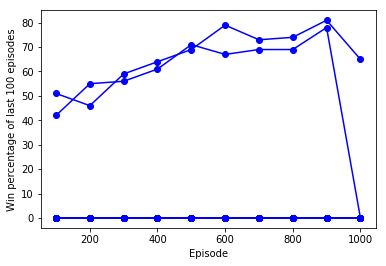

Example policy: 
 [0.18 0.18 0.09 0.09 0.07 0.07 0.04 0.04 0.02 0.02 0.02 0.02 0.02 0.02
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]


KeyboardInterrupt: 

In [9]:
win_pct = np.zeros([10, 10])

for j in range(10):
    AC = ActorCritic(sess = s, entropy = 0.01, learning_rate = 1e-3, gamma = 0.99)
    for i in range(10):

        wins = []

        for _ in range(100):

            env = backgammon()

            states = []
            currstates = []
            afterstates = []
            rewards = []
            afterstates.append([])
            done = False

            while not done:
                dice = B.roll_dice()
                for _ in range(1 + int(dice[0] == dice[1])):

                    possible_moves, possible_boards = env.legal_moves(dice, 1)
                    n_actions = len(possible_moves)

                    if n_actions == 0:
                        break

                    currstates.append(env.board)
                    afterstates.append(env.board)

                    action = AC.sample_action(possible_boards)
                    new_board, reward, done = env.step(possible_moves[action], player = 1)

                    rewards.append(reward)
                    states.append(new_board)

                    if done:
                        break

                if not done:
                    dice = B.roll_dice()

                    for _ in range(1 + int(dice[0] == dice[1])):
                            new_board, reward, done = env.make_move(dice)
                            if done:
                                rewards[-1] = -1
                                break

            afterstates.append(new_board)
            afterstates = afterstates[2:]

            Dones = np.zeros(len(states))
            Dones[-1] = 1

            States = np.vstack(states)
            CurrStates = np.vstack(currstates)
            AfterStates = np.vstack(afterstates)
            Rewards = AC.get_cumulative_rewards(rewards)


            AC.update(states = States, 
                      rewards = Rewards, 
                      currstates = CurrStates,
                      afterstates = AfterStates, 
                      done = Dones)

            wins.append(int(rewards[-1] == 1))

        win_pct[i, j] = np.mean(wins)

        clear_output(True)
        print("Win percentage: ", win_pct[-1])
        plt.figure()
        x = [(n + 1) * 100 for n in range(10)]
        y = (100 * win_pct).astype('int')
        plt.plot(x, y, 'o-', color = "b")
        plt.xlabel('Episode')
        plt.ylabel('Win percentage of last 100 episodes')
        plt.savefig('tensorflow_random.pdf')
        plt.show()
        print("Example policy: \n", AC.ExamplePolicy())
    

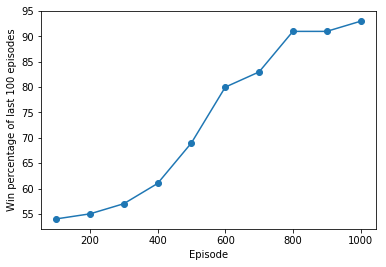

In [34]:
plt.figure()
x = [(n + 1) * 100 for n in range(10)]
y = (100 * np.mean(win_pct, axis = 1)).astype('int')
plt.plot(x, y, 'o-')
plt.xlabel('Episode')
plt.ylabel('Win percentage of last 100 episodes')
plt.savefig('tensorflow_random.pdf')
plt.show()

# Þjálfa Player2 (Policy Gradient)

In [ ]:
win_pct = []


for i in range(10):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        states = []
        afterstates = []
        rewards = []
        afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = PG.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                states.append(new_board)
                afterstates.append(new_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = PG.sample_action(possible_boards)
                        
                        new_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            rewards[-1] = -1
                            break
                            
                env.swap_player()
                            
        afterstates.append(new_board)
        afterstates = afterstates[2:]
        
        Dones = np.zeros(len(states))
        Dones[-1] = 1
        
        States = np.vstack(states)
        Rewards = PG.get_cumulative_rewards(rewards)
        AfterStates = np.vstack(afterstates)
        
        
        PG.update(states = States, 
                      rewards = Rewards, 
                      afterstates = AfterStates, 
                      done = Dones)
        
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    print(PG.ExamplePolicy())
    

# PG vs. Random agent

In [ ]:
win_pct = []


for i in range(5):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        #states = []
        #afterstates = []
        #rewards = []
        #afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = PG.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                #rewards.append(reward)
                #states.append(old_board)
                #afterstates.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                
                for _ in range(1 + int(dice[0] == dice[1])):
                        new_board, reward, done = env.make_move(dice)
                        if done:
                            reward = 0
                            break
                            
        #afterstates.append(old_board)
        #afterstates = afterstates[2:]
        
        #Dones = np.zeros(len(states))
        #Dones[-1] = 1
        
        #States = np.vstack(states)
        #Rewards = player.get_cumulative_rewards(rewards)
        #AfterStates = np.vstack(afterstates)
        
        
        #player.update(states = States, 
        #              rewards = Rewards, 
        #              afterstates = AfterStates, 
        #              done = Dones)
        
        wins.append(reward)
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    

# Keppni

In [ ]:
win_pct = []


for i in range(5):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        #states = []
        #afterstates = []
        #rewards = []
        #afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                #rewards.append(reward)
                #states.append(old_board)
                #afterstates.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = PG.sample_action(possible_boards)
                        
                        new_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            reward = -1
                            break
                            
                env.swap_player()
                            
        #afterstates.append(old_board)
        #afterstates = afterstates[2:]
        
        #Dones = np.zeros(len(states))
        #Dones[-1] = 1
        
        #States = np.vstack(states)
        #Rewards = player.get_cumulative_rewards(rewards)
        #AfterStates = np.vstack(afterstates)
        
        
        #player.update(states = States, 
        #              rewards = Rewards, 
        #              afterstates = AfterStates, 
        #              done = Dones)
        
        wins.append(int(reward == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    

# Þjálfa AC á PG

In [ ]:
win_pct = []


for i in range(100):
    
    wins = []
    
    for _ in range(100):
        
        env = backgammon()
        
        states = []
        afterstates = []
        rewards = []
        afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = AC.sample_action(possible_boards)
                new_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                states.append(new_board)
                afterstates.append(new_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = PG.sample_action(possible_boards)
                        
                        new_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            rewards[-1] = -1
                            break
                            
                env.swap_player()
                            
        afterstates.append(new_board)
        afterstates = afterstates[2:]
        
        Dones = np.zeros(len(states))
        Dones[-1] = 1
        States = np.vstack(states)
        CumulativeRewards = AC.get_cumulative_rewards(rewards)
        AfterStates = np.vstack(afterstates)
        
        
        AC.update(states = States, 
                      rewards = CumulativeRewards,
                      afterstates = AfterStates, 
                      done = Dones)
        
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    print("Example policy: ", AC.ExamplePolicy())
    

# Prófa batch training (Virkar illa)

In [ ]:
win_pct = []



for i in range(1000):
    
    wins = []
    
    States = []
    AfterStates = []
    Rewards = []
    Dones = []
    
    for _ in range(50):
        
        env = backgammon()
        done = False
        
        states = []
        afterstates = []
        rewards = []
        
        afterstates.append([])
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = player.sample_action(possible_boards)
                old_board, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                states.append(old_board)
                afterstates.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                
                for _ in range(1 + int(dice[0] == dice[1])):
                        old_state, reward, done = env.make_move(dice)
                        if done:
                            rewards[-1] = -1
                            break
                            
        afterstates.append(old_board)
        afterstates = afterstates[2:]
        
        dones = np.zeros(len(rewards))
        dones[-1] = 1
        rewards = player.get_cumulative_rewards(rewards)
        
        States.append(states)
        AfterStates.append(afterstates)
        Rewards.append(rewards)
        Dones.append(dones)
        
        wins.append(int(rewards[-1] == 1))
    
    #Rewards = np.concatenate(Rewards).flatten()
    #States = np.vstack(States)
    #AfterStates = np.vstack(AfterStates)
    #Dones = np.concatenate(Dones).flatten()
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    
    for r, s, a, d in zip(Rewards, States, AfterStates, Dones):
        player.update(states = np.vstack(s), 
                      rewards = r, 
                      afterstates = np.vstack(a), 
                      done = d)
    

# Convolutional Agent (Virkar illa)

In [ ]:
class ConvActorCritic:
    def __init__(self, gamma = 0.99, learning_rate = 1e-3, entropy = 0.1):
        
        self._gamma = gamma
        
        self._states = tf.placeholder("float32", (None, 29), name = "states")
        self._states2D = tf.expand_dims(self._states, 2)
        self._afterstates = tf.placeholder("float32", (None, 29), name = "afterstates")
        self._afterstates2D = tf.expand_dims(self._afterstates, 2)
        self._done = tf.placeholder("float32", (None, ), name = "dones")
        self._cumulative_rewards = tf.placeholder("float32", (None, ), name = "rewards")
        
        # Actor
        self.network = keras.models.Sequential()
        self.network.add(L.InputLayer(input_shape = (29, 1)))
        self.network.add(L.Conv1D(kernel_size = 5, filters = 2))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5, filters = 4))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5, filters = 8))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5,filters = 16))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5, filters = 32))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Conv1D(kernel_size = 5, filters = 8))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Flatten())
        self.network.add(L.Dense(128))
        self.network.add(L.LeakyReLU())
        self.network.add(L.Dense(1))
                         
        
        # Predictions
        
        ## Critic
        self._state_values = self.network(self._states2D)
        self._afterstate_values = self.network(self._afterstates2D) * (1 - self._done)
        self._target_state_values = self._cumulative_rewards + self._gamma * self._afterstate_values * (1 - self._done)
        
        self._advantage = self._cumulative_rewards + self._gamma * self._afterstate_values - self._state_values
        
        
        
        ## Actor
        self._actor_logits = self.network(self._states2D)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        self._actor_entropy = -tf.reduce_sum(self._actor_policy * self._actor_log_policy)
        
        # Losses
        self._critic_loss = tf.reduce_mean((self._state_values - tf.stop_gradient(self._target_state_values)))
        self._actor_loss = -tf.reduce_sum(self._actor_log_policy * tf.stop_gradient(self._advantage))
        self._actor_loss -= entropy * self._actor_entropy
        
        self._optimizer = tf.train.AdamOptimizer(learning_rate)
        self._update = self._optimizer.minimize(self._critic_loss + self._actor_loss)
        
        self._s = tf.InteractiveSession()
        self._s.run(tf.global_variables_initializer())
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._states: states})).flatten()
        
        return np.random.choice(np.arange(len(probs)), p = probs)
    
    def update(self, states, rewards, afterstates, done):
        self._s.run(self._update, 
                    ({self._states: states, 
                      self._afterstates: afterstates,
                      self._done: done,
                      self._cumulative_rewards: rewards}))
        
    def get_cumulative_rewards(self, rewards):
        rewards = np.array(rewards)
        R = np.zeros_like(rewards, dtype= "float32")
        r = 0.
        for i, reward in enumerate(reversed(rewards)):
            r += reward
            R[-(i + 1)] = r
            r *= self._gamma
        return R

In [ ]:
win_pct = []

PG = PolicyGradient(sess = s, entropy = 0.1, learning_rate=1e-4, gamma = 0.9)

for i in range(100):
    
    wins = []
    
    for _ in range(10):
        
        env = backgammon()
        
        states = []
        afterstates = []
        actions = []
        rewards = []
        reward_vector = []
        afterstates.append([])
        done = False
        
        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):
                
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)
                
                if n_actions == 0:
                    break
                    
                    
                action = AC.sample_action(possible_boards)
                new, reward, done = env.step(possible_moves[action], player = 1)
                
                rewards.append(reward)
                reward_vector.append(np.zeros(len(possible_boards)))
                states.append(possible_boards)
                actions.append(action)
                afterstates.append(old_board)
                
                if done:
                    break
                    
            if not done:
                dice = B.roll_dice()
                env.swap_player()
                for _ in range(1 + int(dice[0] == dice[1])):
                        possible_moves, possible_boards = env.legal_moves(dice, 1)
                        n_actions = len(possible_moves)
                        
                        if n_actions == 0:
                            break
                        
                        action = PG.sample_action(possible_boards)
                        
                        old_board, reward, done = env.step(possible_moves[action], player = 1)
                        
                        if done:
                            rewards[-1] = -1
                            break
                            
                env.swap_player()
                                     
                            
        afterstates.append(old_board)
        afterstates = afterstates[2:]
        
        CumulativeRewards = PG.get_cumulative_rewards(rewards)
        
        for States, Reward, Reward_vector, Action in zip(states, CumulativeRewards, reward_vector, actions):
            Reward_vector[Action] = Reward
            
            States = np.vstack(States)
            Reward_vector = np.array(Reward_vector)
            
            PG.update(rewards = Reward_vector, states = States, afterstates = 0, done = 0)
        
        
        wins.append(int(rewards[-1] == 1))
    
    win_pct.append(np.mean(wins))
    
    clear_output(True)
    print("Win percentage: ", win_pct[-1])
    plt.plot(win_pct)
    plt.show()
    print("Example policy: \n", PG.ExamplePolicy())
    

# Sér network fyrir Actor og Critic

In [ ]:
class Agent:
    def __init__(self, gamma = 0.99):
        
        self._gamma = gamma
        
        self._states = tf.placeholder("float32", (None, 29), name = "states")
        self._afterstates = tf.placeholder("float32", (None, 29), name = "afterstates")
        self._done = tf.placeholder("float32", (None, ), name = "dones")
        self._cumulative_rewards = tf.placeholder("float32", (None, ), name = "rewards")
        
        # Actor
        self.actor = keras.models.Sequential()
        self.actor.add(L.Dense(32))
        self.actor.add(L.LeakyReLU())
        self.actor.add(L.Dense(64))
        self.actor.add(L.LeakyReLU())
        self.actor.add(L.Dense(32))
        self.actor.add(L.LeakyReLU())
        self.actor.add(L.Dense(1))
        
        # Critic
        
        self.critic = keras.models.Sequential()
        self.critic.add(L.Dense(32))
        self.critic.add(L.LeakyReLU())
        self.critic.add(L.Dense(64))
        self.critic.add(L.LeakyReLU())
        self.critic.add(L.Dense(32))
        self.critic.add(L.LeakyReLU())
        self.critic.add(L.Dense(1))
        
        # Losses and logits
        
        ## Critic
        self._state_values = self.critic(self._states)
        self._afterstate_values = self.critic(self._afterstates) * (1 - self._done)
        self._advantage = self._cumulative_rewards + self._gamma * self._afterstate_values - self._state_values
        
    
        self._target_state_values = self._cumulative_rewards + self._gamma * self._afterstate_values * (1 - self._done)
        
        self._critic_loss = tf.reduce_mean((self._state_values - tf.stop_gradient(self._target_state_values)))
        self._critic_optimizer = tf.train.AdamOptimizer()
        self._critic_update = self._critic_optimizer.minimize(self._critic_loss)
        
        ## Actor
        self._actor_logits = self.actor(self._states)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        
        self._actor_loss = -tf.reduce_sum(self._actor_log_policy * tf.stop_gradient(self._advantage))
        self._actor_optimizer = tf.train.AdamOptimizer()
        self._actor_update = self._actor_optimizer.minimize(self._actor_loss)
        
        self._s = tf.InteractiveSession()
        self._s.run(tf.global_variables_initializer())
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._states: states})).flatten()
        
        return np.random.choice(np.arange(len(probs)), p = probs)
    
    def update(self, boards, rewards, afterstates, done):
        self._s.run([self._actor_update, self._critic_update], 
                    ({self._states: boards, 
                      self._afterstates: afterstates,
                      self._done: done,
                      self._cumulative_rewards: rewards}))
        
    def get_cumulative_rewards(self, rewards):
        rewards = np.array(rewards)
        R = np.zeros_like(rewards, dtype= "float32")
        r = 0.
        for i, reward in enumerate(reversed(rewards)):
            r += reward
            R[-(i + 1)] = r
            r *= self._gamma
        return R